## EDA and Data Preprocessing

The Purpose of this notebook is to take a peek look at the Ultrasound data and perform some basic exploration and data cleanining. 

The goal of the competition was to label the area containing a collection of nerves called the Brachial plexus in ultrasound images. 

**Some pecularities about Data and Methodology**
1. Data is given in Grayscale format and as per patient
2. Many of the images dont contain the BP nerve, so in that case the mask is empty. Need to check how it impacts the model training
3. There is a presence of contradictory labelled images. Many of the images are very similar but one contains a mask and other doesnt. So appropriate cleaning has been done based on image similarity score
4. Finally as an additional step for further post processing, we have stored concatenated and stored all masks into a numpy comrpessed file format (.npz) format for later use

In [3]:
import  sys
import os
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
import warnings
%matplotlib inline

We define the path variables that contain the data and for storing cleaned/preprocessed data

In [9]:
# Define the variables
TRAIN_PATH = r'D:\Work\DL_learn\Datasets\UltrasoundNerveSegmentation\train'
TRAIN_PATH_CLEANED = r'D:\Work\DL_learn\Datasets\UltrasoundNerveSegmentation\train_cleaned'

Below are 2 of the helper functions to load patient wise data

In [10]:
def load_and_preprocess(imgname):
    img_fname = imgname
    mask_fname = os.path.splitext(imgname)[0] + "_mask.tif"
    img = cv2.imread(os.path.join(TRAIN_PATH, img_fname), cv2.IMREAD_GRAYSCALE)
    assert img is not None
    mask = cv2.imread(os.path.join(TRAIN_PATH, mask_fname), cv2.IMREAD_GRAYSCALE)
    assert mask is not None
    
    mask = (mask > 128).astype(np.float32)
    
    img = img.astype(np.float32) / 255.0
    np.ascontiguousarray(img)
    return img, mask


def load_patient(pid):
    fnames = [os.path.basename(fname) for fname in glob.glob(TRAIN_PATH + "/%d_*.tif" % pid) if 'mask' not in fname]
    imgs, masks = zip(*map(load_and_preprocess, fnames))
    imgs = np.array(imgs)
    masks = np.array(masks)
    return imgs, masks, fnames

In [11]:
img_test,masks_test,fnames_test = load_patient(6)

In [12]:
masks_test.shape

(120, 420, 580)

In [13]:
fnames_test[0]

'6_1.tif'

In [17]:
fnames_test

['6_1.tif',
 '6_10.tif',
 '6_100.tif',
 '6_101.tif',
 '6_102.tif',
 '6_103.tif',
 '6_104.tif',
 '6_105.tif',
 '6_106.tif',
 '6_107.tif',
 '6_108.tif',
 '6_109.tif',
 '6_11.tif',
 '6_110.tif',
 '6_111.tif',
 '6_112.tif',
 '6_113.tif',
 '6_114.tif',
 '6_115.tif',
 '6_116.tif',
 '6_117.tif',
 '6_118.tif',
 '6_119.tif',
 '6_12.tif',
 '6_120.tif',
 '6_13.tif',
 '6_14.tif',
 '6_15.tif',
 '6_16.tif',
 '6_17.tif',
 '6_18.tif',
 '6_19.tif',
 '6_2.tif',
 '6_20.tif',
 '6_21.tif',
 '6_22.tif',
 '6_23.tif',
 '6_24.tif',
 '6_25.tif',
 '6_26.tif',
 '6_27.tif',
 '6_28.tif',
 '6_29.tif',
 '6_3.tif',
 '6_30.tif',
 '6_31.tif',
 '6_32.tif',
 '6_33.tif',
 '6_34.tif',
 '6_35.tif',
 '6_36.tif',
 '6_37.tif',
 '6_38.tif',
 '6_39.tif',
 '6_4.tif',
 '6_40.tif',
 '6_41.tif',
 '6_42.tif',
 '6_43.tif',
 '6_44.tif',
 '6_45.tif',
 '6_46.tif',
 '6_47.tif',
 '6_48.tif',
 '6_49.tif',
 '6_5.tif',
 '6_50.tif',
 '6_51.tif',
 '6_52.tif',
 '6_53.tif',
 '6_54.tif',
 '6_55.tif',
 '6_56.tif',
 '6_57.tif',
 '6_58.tif',
 '6_59.ti

A simple function to see the image and its mask (BP nerve segmentation) side by side. We can pass indices to see the particular ultrasound scan of a patient

In [84]:
def show_patient(img,masks,fnames,index=0):
    fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize = (10,8))
    plt.title(fnames[index])
    ax1.imshow(img[index],cmap = 'gray')
    ax2.imshow(masks[index],cmap = 'gray')

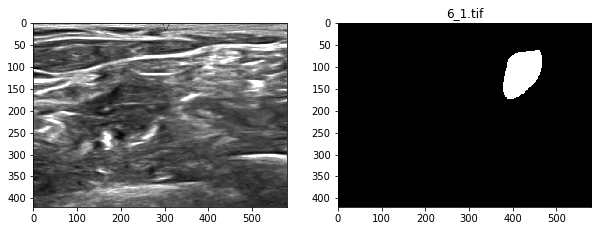

In [85]:
show_patient(img_test,masks_test,fnames_test,0)

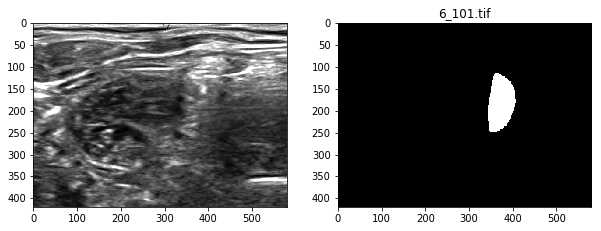

In [86]:
show_patient(img_test,masks_test,fnames_test,3)

Comming to the data cleaning part, we calculate the histogram of intensity of the image and then find out close pair of images using cosine similarity. We then filter these close pairs for per patient based on similarity measure and dice coefficient 

In [87]:
def dice_coefficient(Y_pred, Y):
    """
    This works for one image
    http://stackoverflow.com/a/31275008/116067
    """
    denom = (np.sum(Y_pred == 1) + np.sum(Y == 1))
    if denom == 0:
        # By definition, see https://www.kaggle.com/c/ultrasound-nerve-segmentation/details/evaluation
        return 1
    else:
        return 2 * np.sum(Y[Y_pred == 1]) / float(denom)

def average_dice_coefficient(Y_pred, Y):
    dice_coeffs = []
    for i in range(Y_pred.shape[0]):
        dice_coeffs.append(dice_coefficient(Y_pred[i], Y[i]))
    return np.mean(dice_coeffs)

In [119]:
import skimage.util

def compute_img_hist(img):
    #print(img.shape)
    # Divide the image in blocks and compute per-block histogram
    blocks = skimage.util.view_as_blocks(img, block_shape=(20, 20))
    img_hists = [np.histogram(block, bins=np.linspace(0, 1, 10))[0] for block in blocks]
    return np.concatenate(img_hists)

img = img_test[0]
test_hist = compute_img_hist(img)

(array([86., 40., 20., 19.,  8.,  8.,  3.,  1.,  3.,  1.]),
 array([   0. ,  715.4, 1430.8, 2146.2, 2861.6, 3577. , 4292.4, 5007.8,
        5723.2, 6438.6, 7154. ]),
 <a list of 10 Patch objects>)

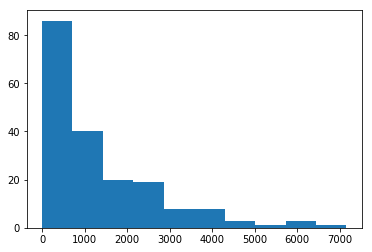

In [120]:
plt.hist(test_hist)

In [121]:
hists = np.array(list(map(compute_img_hist, img_test)))
hists.shape

(120, 189)

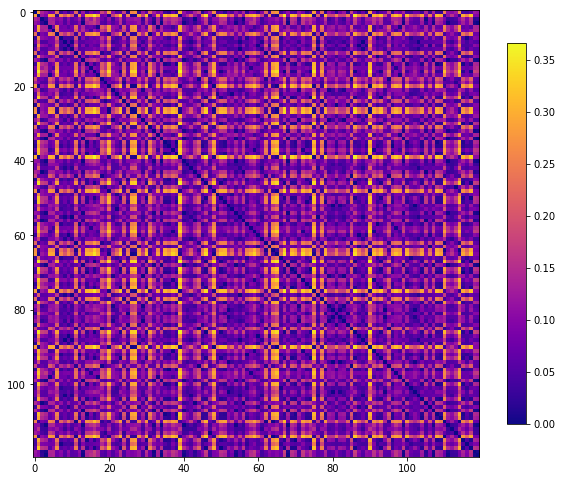

In [125]:
import scipy.spatial.distance as spdist

D = spdist.squareform(spdist.pdist(hists, metric='cosine'))

plt.figure(figsize=(10, 10))
plt.imshow(D, interpolation='nearest',cmap='plasma')
plt.colorbar(shrink=0.7)

In [130]:
close_pairs

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

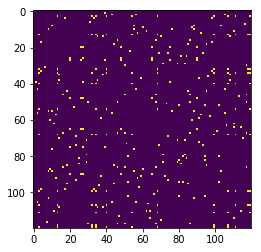

In [126]:
close_pairs = D + np.eye(D.shape[0]) < 0.008
plt.imshow(close_pairs)

In [135]:
close_ij = np.transpose(np.nonzero(close_pairs))
print(close_ij.shape)

(346, 2)


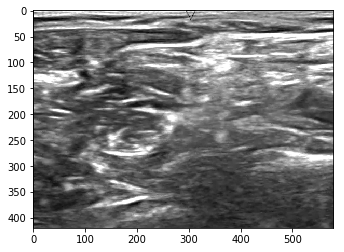

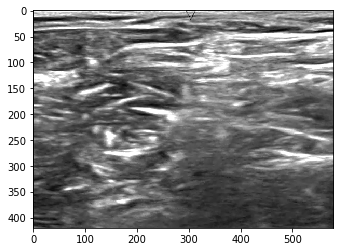

In [138]:
farthest = np.argmax(D[close_pairs])

plt.imshow(img_test[close_ij[farthest, 0]],cmap = 'gray')
plt.figure()
plt.imshow(img_test[close_ij[farthest, 1]],cmap = 'gray')

### Cleaning data for all the patients 

In [148]:
def filter_images_for_patient(pid):
    imgs, masks, fnames = load_patient(pid)
    hists = np.array(list(map(compute_img_hist, imgs)))
    D = spdist.squareform(spdist.pdist(hists, metric='cosine'))
    
    # Used 0.005 to train at 0.67
    close_pairs = D + np.eye(D.shape[0]) < 0.008
    
    close_ij = np.transpose(np.nonzero(close_pairs))
    
    incoherent_ij = [(i, j) for i, j in close_ij if dice_coefficient(masks[i], masks[j]) < 0.2]
    incoherent_ij = np.array(incoherent_ij)
    
    #i, j = incoherent_ij[np.random.randint(incoherent_ij.shape[0])]
    
    valids = np.ones(len(imgs), dtype=np.bool)
    for i, j in incoherent_ij:
        if np.sum(masks[i]) == 0:
            valids[i] = False
        if np.sum(masks[j]) == 0:
            valids[i] = False

    for i in np.flatnonzero(valids):
        imgname = os.path.splitext(fnames[i])[0] + ".png"
        mask_fname = os.path.splitext(imgname)[0] + "_mask.png"
        img = skimage.img_as_ubyte(imgs[i])
        cv2.imwrite(os.path.join(TRAIN_PATH_CLEANED, imgname), img)
        mask = skimage.img_as_ubyte(masks[i])
        cv2.imwrite(os.path.join(TRAIN_PATH_CLEANED, mask_fname), mask)
    print('Discarded ' +  str(np.count_nonzero(~valids)) +  " images for patient " + str(pid))

In [150]:
for pid in range(1, 48):
    filter_images_for_patient(pid)

C:\Users\mohit\Anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


Discarded 67 images for patient 1
Discarded 8 images for patient 2
Discarded 16 images for patient 3
Discarded 30 images for patient 4
Discarded 50 images for patient 5
Discarded 37 images for patient 6
Discarded 52 images for patient 7
Discarded 41 images for patient 8
Discarded 19 images for patient 9
Discarded 52 images for patient 10
Discarded 40 images for patient 11
Discarded 28 images for patient 12
Discarded 36 images for patient 13
Discarded 57 images for patient 14
Discarded 36 images for patient 15
Discarded 19 images for patient 16
Discarded 31 images for patient 17
Discarded 31 images for patient 18
Discarded 41 images for patient 19
Discarded 18 images for patient 20
Discarded 54 images for patient 21
Discarded 34 images for patient 22
Discarded 36 images for patient 23
Discarded 13 images for patient 24
Discarded 36 images for patient 25
Discarded 51 images for patient 26
Discarded 26 images for patient 27
Discarded 30 images for patient 28
Discarded 33 images for patien

As a last step we then store all the mask in .npz format for later post processing

### Form .npz file of cleaned data

In [32]:
TRAIN_PATH = r'D:\Work\DL_learn\Datasets\UltrasoundNerveSegmentation\train_cleaned\\'

In [45]:
def load_and_preprocess_cleaned(imgname):
    img_fname = imgname
    mask_fname = os.path.splitext(imgname)[0] + "_mask.png"
    img = cv2.imread(os.path.join(TRAIN_PATH, img_fname), cv2.IMREAD_GRAYSCALE)
    assert img is not None
    mask = cv2.imread(os.path.join(TRAIN_PATH, mask_fname), cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask,(128,128))
    assert mask is not None
    
    mask = (mask > 128).astype(np.float32)
    
    img = img.astype(np.float32) / 255.0
    np.ascontiguousarray(img)
    return img, mask

In [46]:
def load_patient_cleaned(pid):
    fnames = [os.path.basename(fname) for fname in glob.glob(TRAIN_PATH + "/%d_*.png" % pid) if 'mask' not in fname]
    #print(fnames)
    imgs, masks = zip(*map(load_and_preprocess_cleaned, fnames))
    imgs = np.array(imgs)
    masks = np.array(masks)
    return imgs, masks, fnames

In [50]:
masks_combined = np.empty((1,128,128))

In [51]:
for pid in range(1,48):
    print('Loading patient data for - ' + str(pid))
    _,masks,_ = load_patient_cleaned(pid)
    #print(masks.shape)
    masks_combined = np.concatenate((masks_combined,masks))

Loading patient data for - 1
Loading patient data for - 2
Loading patient data for - 3
Loading patient data for - 4
Loading patient data for - 5
Loading patient data for - 6
Loading patient data for - 7
Loading patient data for - 8
Loading patient data for - 9
Loading patient data for - 10
Loading patient data for - 11
Loading patient data for - 12
Loading patient data for - 13
Loading patient data for - 14
Loading patient data for - 15
Loading patient data for - 16
Loading patient data for - 17
Loading patient data for - 18
Loading patient data for - 19
Loading patient data for - 20
Loading patient data for - 21
Loading patient data for - 22
Loading patient data for - 23
Loading patient data for - 24
Loading patient data for - 25
Loading patient data for - 26
Loading patient data for - 27
Loading patient data for - 28
Loading patient data for - 29
Loading patient data for - 30
Loading patient data for - 31
Loading patient data for - 32
Loading patient data for - 33
Loading patient dat

In [52]:
masks_combined.shape

(3907, 128, 128)

In [53]:
np.savez('Masks_pca_data.npz',masks_combined)